In [1]:
"""
Data pipeline and augmentation for the minority class, '1.0', with a TensorFlow implementation.
Author: Booy Faassen
"""

import tensorflow as tf

import pathlib
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
import math

import tensorflow_addons as tfa #addons

from datetime import datetime
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
import psutil
    
tf.get_logger().setLevel('ERROR') #disable info and warning messages from Tensorflow. Still shows error messages.

In [22]:
"""
Custom augmentation function
following tutorials from: https://www.tensorflow.org/tutorials/images/data_augmentation#custom_data_augmentation
and: https://stackoverflow.com/questions/69689159/how-to-set-possbility-to-tf-keras-layers-randomflip
"""

""" Random vertical flip """
class CustomVerticalFlip(tf.keras.layers.Layer):
    def __init__(self, p=0.5, **kwargs):
        super().__init__(**kwargs)
        self.p = p
    
    def call(self, x):
        return tf.cond(tf.random.uniform([]) < self.p, lambda: tf.image.flip_up_down(x), lambda: x)

""" Random horizontal flip """
class CustomHorizontalFlip(tf.keras.layers.Layer):
    def __init__(self, p=0.5, **kwargs):
        super().__init__(**kwargs)
        self.p = p
    
    def call(self, x):
        return tf.cond(tf.random.uniform([]) < self.p, lambda: tf.image.flip_left_right(x), lambda: x)

"""
Random Gaussian blur
sigma: the standard deviation for blurring kernel. Uniformly and randomly chosen between given range.
"""
class CustomGaussianBlur(tf.keras.layers.Layer):
    def __init__(self, p=0.5, filter_size = 13, sigma_min = 0.1, sigma_max = 2.0, **kwargs):
        super().__init__(**kwargs)
        self.p = p
        self.filter_size = filter_size
        sigma2 = random.uniform(sigma_min, sigma_max)
        self.sigma = random.uniform(sigma_min, sigma_max)
    
    def call(self, x):
        return tf.cond(tf.random.uniform([]) < self.p,
                       lambda: tfa.image.gaussian_filter2d(x, filter_shape = self.filter_size, sigma = self.sigma),
                       lambda: x)

""" Random rotation """
class CustomRotate(tf.keras.layers.Layer):
    def __init__(self, p=0.5, angle=5, **kwargs):
        super().__init__(**kwargs)
        self.p = p,
        angle_r = (angle*math.pi)/180 # convert degrees to radians
        self.angle = random.uniform(-1*angle_r, angle_r)
    
    def call(self, x):
        return tf.cond(tf.random.uniform([]) < self.p, lambda: tfa.image.rotate(x, angles=self.angle), lambda: x)

""" Random resized crop """
class CustomResizedCrop(tf.keras.layers.Layer):
    # largely inspired by
    # https://stackoverflow.com/questions/65164442/is-there-an-equivalent-to-pytorchs-randomresizedcrop-in-tensorflow
    def __init__(self, scale=(0.8, 1), image_size=[256, 256], ratio=(0.75, 1.3333333333333333), **kwargs):
        super().__init__(**kwargs)
        self.size = image_size
        self.scale = scale
        self.ratio = ratio
    
    def call(self, x):
        batch_size = tf.shape(x)[0]
        
        random_scales = tf.random.uniform((batch_size,), self.scale[0], self.scale[1])
        
        random_ratios = tf.exp(tf.random.uniform((batch_size,), self.ratio[0], self.ratio[1]))
        
        height_new = tf.clip_by_value(tf.sqrt(random_scales / random_ratios), 0, 1,)
        width_new = tf.clip_by_value(tf.sqrt(random_scales / random_ratios), 0, 1,)
        height_offset = tf.random.uniform((batch_size,), 0, 1-height_new,)
        width_offset = tf.random.uniform((batch_size,), 0, 1-width_new,)
        
        bounding_boxes = tf.stack(
            [
                height_offset,
                width_offset,
                height_offset + height_new,
                width_offset + width_new,
            ],
            axis=1,
        )
        x = tf.image.crop_and_resize(x, boxes=bounding_boxes, box_indices=tf.range(batch_size), crop_size=self.size)
        return x

""" Shear - Does not work as the tensor must first be converted to a numpy image. """
class CustomShear(tf.keras.layers.Layer):
    def __init__(self, intensity=5, fill_mode='constant', **kwargs):
        super().__init__(**kwargs)
        self.intensity = random.uniform(-1*intensity, intensity)
        self.fill_mode = fill_mode
        
    def call(self, x):
        return tf.keras.preprocessing.image.random_shear(x, intensity=self.intensity, fill_mode=self.fill_mode, cval=0.0)

In [1]:
data_augmentation = tf.keras.Sequential([
    #tf.keras.layers.Resizing(224, 224), # this is redundant as the images are already this size.
    CustomHorizontalFlip(),
    CustomVerticalFlip(),
    CustomRotate(),
    #RandomResizedCrop() The problem is that 'x' (the image) is in 3 dim and should be in 4 dim instead.
    #CustomResizedCrop() The problem is that 'x' (the image) is in 3 dim and should be in 4 dim instead.
    #CustomShear(), Current implementation does not work
    CustomGaussianBlur()
    # ToTensor not neccessary as the images are already converted
    tf.keras.layers.Normalization(axis=-1, mean=0, variance=1, invert=False)
])

SyntaxError: invalid syntax. Perhaps you forgot a comma? (3440828034.py, line 9)

In [24]:
"""
Custom dataset loader
Tutorial (with my own modifications) from:
https://www.tensorflow.org/tutorials/load_data/images#using_tfdata_for_finer_control
"""

""" Create a custom dataset """
def create_dataset(data_dir, batch_size, img_height, img_width, labels, aug_technique, aug=True):
    if aug == False:
        raise ValueError("This implementation only supports data augmentation for the minority class, '1.0'.")
    
    count = 0
    for i in os.walk(data_dir):
        count += len(os.listdir(i[0]))
    image_count = count - 2 # subtract 2 to account for the '0.0' and '1.0' folders

    AUTOTUNE = tf.data.AUTOTUNE

    list_ds = tf.data.Dataset.list_files(str(data_dir + '/*/*'), shuffle=False)
    train_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=False)

    # Splitting into training and validation:
    # val_size = int(image_count * val_split)
    # train_ds = list_ds.skip(val_size)
    # val_ds = list_ds.take(val_size)
    
    # Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
    train_ds = train_ds.map(lambda file_path: process_path(file_path, data_augmentation, img_height, img_width), 
                            num_parallel_calls=AUTOTUNE)

    train_ds = configure_for_performance(train_ds, batch_size)
    #val_ds = configure_for_performance(val_ds)

    return train_ds
    
    
""" Convert a file path to an (img, label) pair: """
def get_label_for_aug(file_path):
    # Convert the path to a list of path components
    parts = tf.strings.split(file_path, os.path.sep)
    one_hot = parts[-2] == class_names # The second to last is the class-directory
    return tf.argmax(one_hot) # Integer encode the label

""" Convert a file path to an (img, label) pair: """
def get_label(file_path):
    # Convert the path to a list of path components
    parts = tf.strings.split(file_path, os.path.sep)
    val = parts[-2]
    if val == b'0.0':
        return tf.constant([1.0, 0.0])
    else:
        return tf.constant([0.0, 1.0])

def decode_img(img, img_height, img_width):
    # Convert the compressed string to a 3D uint8 tensor
    img = tf.io.decode_jpeg(img, channels=3)
    # Resize the image to the desired size
    return tf.image.resize(img, [img_height, img_width])

def process_path(file_path, data_augmentation, img_height, img_width):
    label = get_label(file_path)
    label_for_aug = get_label_for_aug(file_path)
    # Load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img, img_height, img_width)
    """ Augment only label 1 """
    if label_for_aug == 1:
        img = data_augmentation(img)
    return img, label

def configure_for_performance(ds, batch_size):
    ds = ds.cache()
    ds = ds.shuffle(buffer_size=1000)
    ds = ds.batch(batch_size)
    #ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

# The below is to augment all data in the train_ds dataset.
# aug_train_ds = train_ds.map(lambda x, y: (data_augmentation(x), y))

In [25]:
""" 
Call the dataset loader.
Manually adjust these parameters based on the dataset in question
"""

data_dir = './data/dataset01/train'
bs = 32
img_height = 224
img_width = 224
class_names = ['0.0', '1.0']

# Create dataset
train_ds = create_dataset(data_dir = data_dir,
                          batch_size = bs,
                          img_height = img_height,
                          img_width = img_width,
                          labels = class_names,
                          aug_technique = data_augmentation,
                          aug=True
                         )

In [30]:
def visualize_random_data(dataset = train_ds):
    """ Visualize 9 samples from the data"""
    image_batch, label_batch = next(iter(train_ds))
    plt.figure(figsize=(10, 10))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        label = label_batch[i]
        title = 'Label: ' + class_names[int(label.numpy()[1])]
        plt.title(title)
        plt.axis("off")

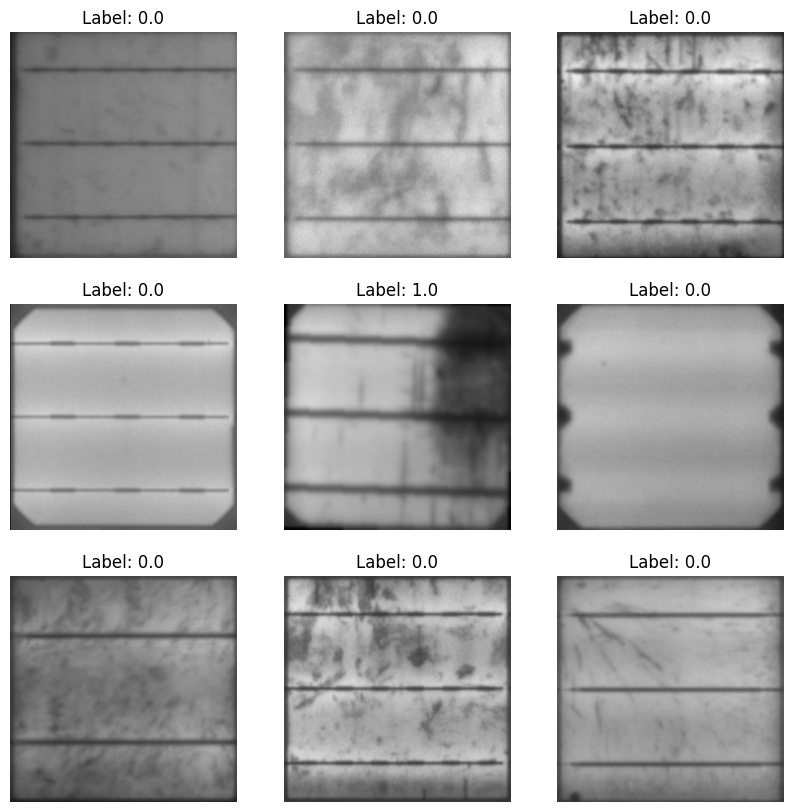

In [31]:
visualize_random_data(train_ds)

In [ ]:
"""
The below is no longer part of the augmentation and dataloading pipeline.
Instead, it validates that the pipeline works for training a model with.
"""

In [17]:
""" Set metrics for later use """

METRICS = [
    tf.keras.metrics.Accuracy(name='acc'),
    tf.keras.metrics.TruePositives(name='tp'),
    tf.keras.metrics.FalsePositives(name='fp'),
    tf.keras.metrics.TrueNegatives(name='tn'),
    tf.keras.metrics.FalseNegatives(name='fn'), 
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),
    tf.keras.metrics.AUC(name='auc'),
    tf.keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

In [27]:
"""
Building the InceptionV3 model
The code is modified such that it does not have a flag for augmentation in the build_model.
Instead, this flag exists in the create_dataset() function.
"""

def build_model(num_classes, metrics, img_height, img_width):
    inputs = tf.keras.layers.Input(shape=(img_height, img_width, 3))
    inputs_re = tf.keras.layers.experimental.preprocessing.Rescaling(scale=1./127.5, offset=-1)(inputs)
    y = inputs_re
    
    model_input=InceptionResNetV2(include_top=False, weights="imagenet", input_tensor=inputs_re)

    # Freeze the pretrained weights
    model_input.trainable = False
    # add a global spatial average pooling layer
    x = model_input.output
    x = tf.keras.layers.Flatten()(x)
    #x = tf.keras.layers.GlobalAveragePooling2D()(x)
    # let's add a fully-connected layer
    #x = tf.keras.layers.Dense(1024, activation='relu')(x)
    # and a logistic layer
    predictions = tf.keras.layers.Dense(num_classes, activation='softmax')(x) # try sigmoid also for binary classification
    # this is the model we will train
    model = tf.keras.models.Model(inputs_re, predictions)
    
    # compile the model (should be done *after* setting layers to non-trainable)
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)
    model.compile(optimizer, loss='categorical_crossentropy', metrics=metrics)
    return model

In [19]:
model = build_model(num_classes=2, metrics=METRICS, img_height=img_height, img_width=img_width)

In [21]:
hist_m = model.fit(train_ds,
                   epochs=1,
                   steps_per_epoch=len(train_ds),
                   verbose=1 )

62/62 [==============================] - 148s 2s/step - loss: 9272.6182 - acc: 0.6257 - tp: 1234.0000 - fp: 735.0000 - tn: 1234.0000 - fn: 735.0000 - accuracy: 0.6267 - precision: 0.6267 - recall: 0.6267 - auc: 0.6265 - prc: 0.5975


1/1 - 2s - 2s/epoch - 2s/step
prediction: 1.0
actual: 1.0


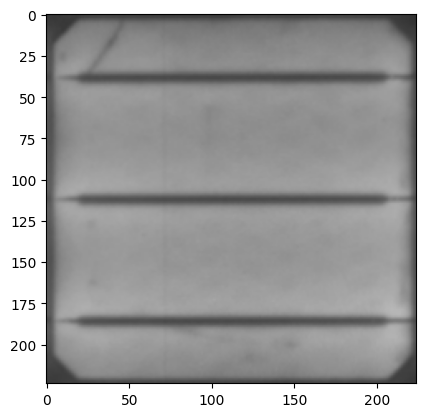

In [68]:
image_batch, label_batch = iter(train_ds).get_next()

pred = model.predict(image_batch, verbose=2)

print('prediction: ' + str(pred[0][1]))
print('actual: ' + str(label_batch[0][1].numpy()))
plt.imshow(image_batch[0].numpy().astype("uint8"))
plt.show()

In [ ]:
print(hist_m.history)

{'loss': [9272.6181640625], 'acc': [0.6256983280181885], 'tp': [1234.0], 'fp': [735.0], 'tn': [1234.0], 'fn': [735.0], 'accuracy': [0.6267140507698059], 'precision': [0.6267140507698059], 'recall': [0.6267140507698059], 'auc': [0.6265243887901306], 'prc': [0.5975245237350464]}
